# Build the inputs required to run inference on our 91 day $\Delta$FAC model
Required inputs:
1. 1980 - 2021 temperature climatology (C)
2. 91 day average temperature (C)
3. 1980 - 2021 precipitation climatology (mm/hr)
4. 91 day average precipitation (mm/hr)
5. 91 - 180 day average precipitation (mm/hr)
6. 180 - 365 day average precipitation (mm/hr)
7. 365 - 730 day average precipitation (mm/hr)
8. Date sine
9. Date cosine
10. Random Forest SMB peturbation

In [31]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import xarray as xr
from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Utility functions

In [32]:
def datetime_to_date_sine_cosine(t):
    doy = t.timetuple().tm_yday
    day_sin = np.sin(doy*(2.*np.pi/365))
    day_cos = np.cos(doy*(2.*np.pi/365))
    return day_sin, day_cos

def lat_lon_to_epsg3031(tgt_lat, tgt_lon):
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo
    
    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)
    
    # Initialize arrays
    tgt_x = np.zeros(len(tgt_lat)); tgt_x[:] = np.nan
    tgt_y = np.zeros(len(tgt_lat)); tgt_y[:] = np.nan
    
    # Perform transformation
    for j in range(0, len(tgt_x)):
        coords = transform.TransformPoint(float(tgt_lat[j]), float(tgt_lon[j]))
        tgt_x[j], tgt_y[j] = coords[0:2]
    
    return tgt_x, tgt_y

# Function to get ratio at lat/lon
def get_RF_M2_ratio(tgt_lat, tgt_lon):
    
    # Get M2 SMB at lat/lon
    M2_smb = xr.open_dataset("M2_annual-mean-SMB.nc")
    M2_smb = M2_smb['__xarray_dataarray_variable__']
    M2_smb = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values
        
    # Get RF at lat/lon
    tgt_x, tgt_y = lat_lon_to_epsg3031(tgt_lat, tgt_lon)
    tgt_x = xr.DataArray(tgt_x, dims="points")
    tgt_y = xr.DataArray(tgt_y, dims="points")
    M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")
    M2_RF = M2_RF['IS2_opt'].sel(x=tgt_x, y=tgt_y, method='nearest').values
    
    # Get ratio
    RF_ratio = (M2_RF + M2_smb) / M2_smb
    RF_ratio = np.nan_to_num(RF_ratio, nan=1)
    
    return RF_ratio

# First, define target information

In [33]:
# Lat/lon
tgt_lat = np.linspace(-90, -75, 100)
tgt_lon = np.repeat(-90, len(tgt_lat))
np.savetxt("inference_lat_lon.txt", np.transpose(np.stack([tgt_lat, tgt_lon])))
np.transpose(np.stack([tgt_lat, tgt_lon]))
tgt_lat = xr.DataArray(tgt_lat, dims="points")
tgt_lon = xr.DataArray(tgt_lon, dims="points")

# Date
t0 = datetime.datetime(2020, 1, 1)
tf = t0 + datetime.timedelta(days=91)
print(t0)
print(tf)

2020-01-01 00:00:00
2020-04-01 00:00:00


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


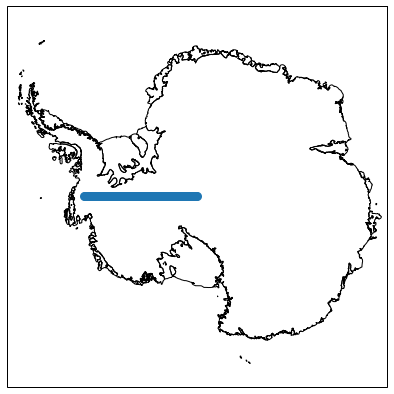

In [34]:
# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(7, 7))

# Plot sites
plt.scatter(tgt_lon, tgt_lat, linewidth=3, transform=ccrs.PlateCarree())


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# 1. Temperature climatology

In [35]:
M2_T2M = xr.open_mfdataset("/scratch/summit/erke2265/MERRA2/T2M_daily_*.nc", combine='nested', concat_dim='time')
T2M_climatology = M2_T2M['T2M'].mean(dim='time')
T2M_climatology = T2M_climatology.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values # Units: C

# 2. 91 day average temperature

In [36]:
tf_ind = np.where(M2_T2M['time'] == np.datetime64(tf))[0][0]
T2M_91_day = M2_T2M['T2M'][tf_ind - 90:tf_ind+1, :, :].mean(dim='time')
T2M_91_day = T2M_91_day.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values
M2_T2M.close()

# 3. 1980 - 2021 precipitation climatology (mm/hr)

In [37]:
M2_PSUM = xr.open_dataset("M2_PSUM_1980-2021.nc")['__xarray_dataarray_variable__']
PSUM_climatology = M2_PSUM.mean(dim='time')
PSUM_climatology = 3600 * PSUM_climatology.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values # Units: mm/hr

# 4. - 7. 91 day, 91 - 180 day, 180 - 365 day, 365 - 730 day mean precip (mm/hr)

In [38]:
# 91 day
PSUM_91_day = M2_PSUM[tf_ind - 90:tf_ind+1, :, :].mean(dim='time')
PSUM_91_day = 3600 * PSUM_91_day.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values # Units: mm/hr

# 91 - 180 day
PSUM_91 = M2_PSUM[tf_ind - 90:tf_ind+1, :, :].mean(dim='time')
PSUM_180 = M2_PSUM[tf_ind - 179:tf_ind+1, :, :].mean(dim='time')
PSUM_180_day = (180 * PSUM_180 - 91 * PSUM_91) / (180 - 91)
PSUM_180_day = 3600 * PSUM_180_day.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values # Units: mm/hr

# 180 - 365 day
PSUM_365 = M2_PSUM[tf_ind - 364:tf_ind+1, :, :].mean(dim='time')
PSUM_365_day = (365 * PSUM_365 - 180 * PSUM_180) / (365 - 180)
PSUM_365_day = 3600 * PSUM_365_day.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values # Units: mm/hr

# 365 - 730 day
PSUM_730 = M2_PSUM[tf_ind - 729:tf_ind+1, :, :].mean(dim='time')
PSUM_730_day = (730 * PSUM_730 - 365 * PSUM_365) / (730 - 365)
PSUM_730_day = 3600 * PSUM_730_day.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values # Units: mm/hr

# 8. - 9. Date sine and cosine

In [39]:
tf_sine, tf_cosine = datetime_to_date_sine_cosine(tf)

# 10. Random Forest SMB Perturbation

In [40]:
RF_ratio = get_RF_M2_ratio(tgt_lat, tgt_lon)

# Compile into an inference array `inference.txt`

In [41]:
# Features
x1 = T2M_climatology
x2 = T2M_91_day
x3 = PSUM_climatology
x4 = PSUM_91_day
x5 = PSUM_180_day
x6 = PSUM_365_day
x7 = PSUM_730_day
x8 = np.repeat(tf_sine, len(x1))
x9 = np.repeat(tf_cosine, len(x1))
x10 = RF_ratio

# Compile into array
inference = np.transpose(np.stack([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]))
print(inference.shape)

# Save array
np.savetxt("inference.txt", inference)

(100, 10)
